# Dataset labeling

created by Martin Hasal for personal use. I am not responsible for any issues created by this Jupyter Notebook. In any way, I decided to keep it simple and others can modify this jupyter notebook by their needs.

This notebook, loads all images (**.jpg** by default) in given folder (**Path must be declared**) and subfolders. Randomly displays images and let users to label images by binary choice. The path, name, label, and time is stored in external `labels.csv` file.

In [124]:
# imports
import os, random, time
from pathlib import Path
from ipywidgets import Output, Button, Layout, HBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline


**declare classes**

In [21]:
CLASSES = ['Good', 'Wrong']

**declare Name of person who does the labeling**

In [22]:
AUTHOR = 'Martin'

**path to images - INPUT**

In [163]:
PATH = 'D:\\Dropbox (ARG@CS.FEI.VSB)\\Dataset - retiny\\images_from_doctor\\ML\\ML_GEN'

In [164]:
def get_files(path, endswith=".jpg", startsnotwith="export_summary"): # exclude startwith
    # load images
    files_original = []
    files_names = []
    files_folders = []

    # find only .jpg 
    for r, d, f in os.walk(path):
        # sorting files alphabetically for Unix-like systems
        for file in sorted(f):
            if file.endswith(endswith) and not file.startswith(startsnotwith):
                #print(os.path.join(r, file))
                files_original.append(os.path.join(r, file))
                # stack names
                files_names.append(file)
        files_folders.append(r)
    
    return files_original, files_names, files_folders


img_paths, img_names, _ = get_files(PATH)
print(f'Number of loaded .jpg images is: {len(img_names)}')

Number of loaded .jpg images is: 38408


**Display random images** to check the readability (you can run the cell multiple times)

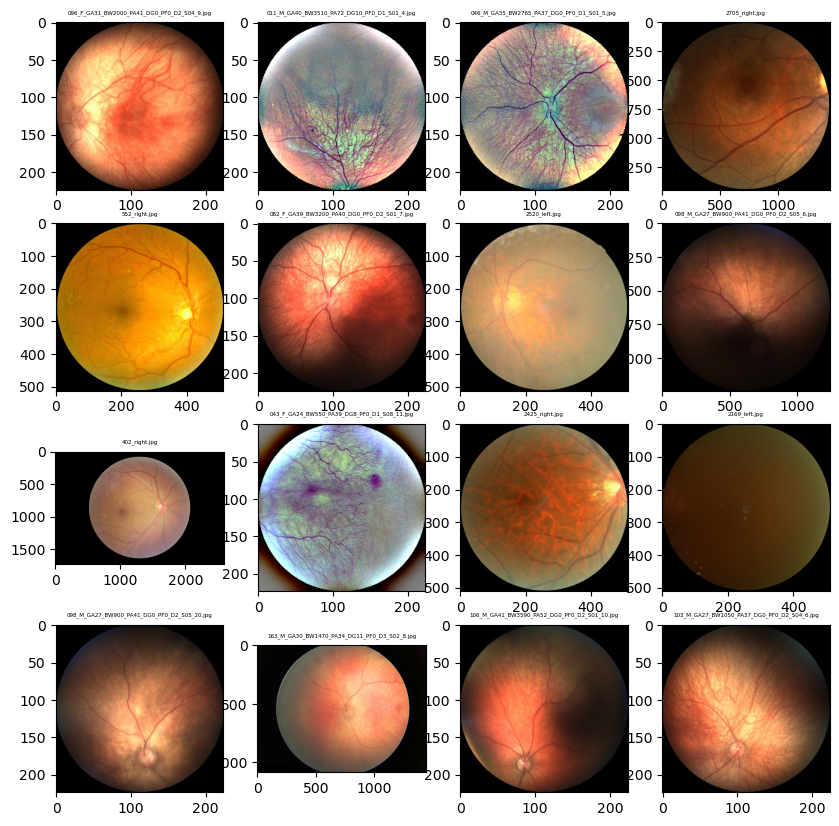

In [165]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
cols = 4
rows = 4
for i in range(1, cols*rows +1):
    indx = random.randint(0, len(img_paths))
    img = mpimg.imread(img_paths[indx])
    fig.add_subplot(rows, cols, i)
    name = os.path.basename(os.path.normpath(img_paths[indx]))
    plt.gca().set_title(name,  fontsize=4)
    plt.imshow(img)
plt.show()

# Labeling tool

In [166]:
class LabelDataset:
    """Class for image labeling by Jupiter Notebook.
    
    Attributes:
        classes: list -> List of classes for labeling
        paths: list -> List of pathes to images (given by search file algorithm)
        img_names: -> List of image names (given by search file algorithm, for simple title finding)
        
    Returns
         labels: dict -> Dictionary with assigned  {'filename': 'label'}.
    Sligtly motivated by 
        https://dida.do/blog/how-to-implement-a-labeling-tool-for-image-classification-in-a-jupyter-notebook
        but their solution can handle only .png images, does not have timer, does not produce pandas results, etc.
        """

    def __init__(
        self,
        classes: list,
        paths: list,
        img_names: list,
        author: str,
        shuffle: bool = True,
        position: int = 0        
    ) -> None:
        """Construct all necessary attributes for the LabelingTool object.
        Args:
            classes: List of candidate labels (typically strings).
            path: Path to the directory containing the images to be labeled.
        """
        # list of available labels
        self.classes = classes

        # store path and list of images in path
        self.paths = paths
        self.images = img_names
        
        # name of label autor
        self.author = author
        
        # list of random indexes to shuffle the dataset or not
        if shuffle:
            self.indx = random.sample(range(len(img_names)), len(img_names)) 
        else:
            self.indx = list(range(len(img_names)))       

        # set up empty dict for labels and initial position
        self.labels = {}
        self.position = position
        
        # create pd DataArray [image name, path, label, label author, time ]
        self.df = pd.DataFrame({'NAME': pd.Series(dtype='str'),
                                'PATH': pd.Series(dtype='str'),
                                'LABEL': pd.Series(dtype='str'),
                                'AUTHOR': pd.Series(dtype='str'),
                                'TIME': pd.Series(dtype='float')})
        
        # timers
        self.st = time.time()
        self.et = time.time()
        

    def _next(self, *args) -> None:
        """Select the next image and updates the displays.
        Args:
            *args: Variable length argument list, allows to pass Button object.
        """
        # update position
        self.position += 1
        if self.position == len(self.images):
            self.position = 0

        # refresh display
        self.st = time.time()
        self._show_img(self.position)

    def _go_back(self, *args) -> None:
        """Select the previous image and updates the displays.
        Do not do anything if it is the first image.
        Args:
            *args: Variable length argument list, allows to pass Button object.
        """
        # update position
        self.position -= 1
        if self.position == -1:
            self.position = len(self.images) - 1

        # refresh display
        self.st = time.time()
        self._show_img(self.position)
        

    def _select_label(self, button: Button) -> None:
        """Attach a label to the current image and stores it.
        Link the label from a given button to the current image and store it
        in the labels dictionary and in the current working directory as .json.
        Args:
            button (ipywidgets.Button): a button supplying the label to be
                associated with the current image
        """
        # store label
        current_image = self.images[self.indx[self.position]]
        self.labels[current_image] = button.description
        
        # store label information to df
        self.et = time.time()
        new_row = {'NAME': self.images[self.indx[self.position]], 
                   'PATH': img_paths[self.indx[self.position]], 
                   'LABEL': button.description, 
                   'AUTHOR': self.author,
                   'TIME': (self.et - self.st)}
        if self.images[self.indx[self.position]] in self.df.NAME.values: # remove existing label if is changed by prev button
            self.df = self.df[self.df['NAME'].str.contains(self.images[self.indx[self.position]]) == False]
        self.df = self.df.append(new_row, ignore_index=True)


        # move on
        self._next()
    
    def _show_img(self, *args) -> None:
        """Display image"""
        # clear input every time, this is only solution with matplotlib
        clear_output(wait=True)
        
        # navigation buttons
        backward_button = Button(description="< go back")
        backward_button.on_click(self._go_back)
        forward_button = Button(description="next >")
        forward_button.on_click(self._next)
        self.navigation_buttons = [backward_button, forward_button]

        # class label buttons
        self.class_buttons = []
        for label in self.classes:
            label_button = Button(description=label)
            label_button.on_click(self._select_label)
            self.class_buttons.append(label_button)

        # display contents
        display(HBox(self.navigation_buttons))
        display(HBox(self.class_buttons))
        
        # display image
        fig = plt.figure(figsize=(5, 5))
        img = mpimg.imread(img_paths[self.indx[self.position]])
        name = os.path.basename(os.path.normpath(img_paths[self.indx[self.position]]))
        plt.gca().set_title(name,  fontsize=8)
        plt.imshow(img)
        
        
        

    def run(self) -> None:
        """Run the interface """
        # display labeling scheme
        self.st = time.time()
        self._show_img()


In [167]:
labels = LabelDataset(paths = img_paths,img_names = img_names, classes=CLASSES, author=AUTHOR)

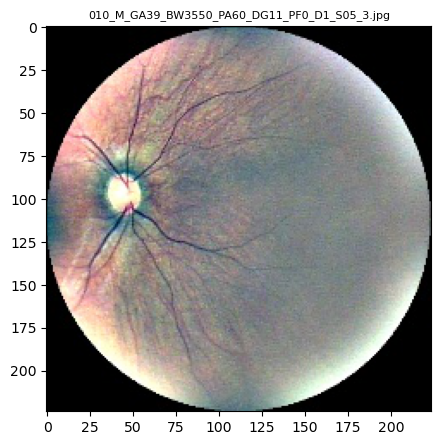

In [168]:
labels.run()

In [169]:
print(labels.labels)

{'1836_left.jpg': 'Good', '143_M_GA32_BW1990_PA33_DG0_PF0_D3_S01_6.jpg': 'Wrong', '4573_right.jpg': 'Good', '4380_right.jpg': 'Good', '2527_right.jpg': 'Good', '4137_left.jpg': 'Wrong', '001_F_GA41_BW2905_PA47_DG11_PF0_D1_S02_18.jpg': 'Wrong'}


In [171]:
labels.df

,NAME,PATH,LABEL,AUTHOR,TIME
0,1836_left.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Good,Martin,3.631330
1,143_M_GA32_BW1990_PA33_DG0_PF0_D3_S01_6.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Wrong,Martin,3.087939
2,4573_right.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Good,Martin,2.450155
3,4380_right.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Good,Martin,3.240889
4,2527_right.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Good,Martin,2.481799
5,4137_left.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Wrong,Martin,3.453607
6,001_F_GA41_BW2905_PA47_DG11_PF0_D1_S02_18.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Wrong,Martin,1.844847
7,139_F_GA24_BW550_PA35_DG3_PF2_D2_S05_23.jpg,D:\Dropbox (ARG@CS.FEI.VSB)\Dataset - retiny\i...,Wrong,Martin,9.183241


In [172]:
labels.df.NAME[0]

'1836_left.jpg'

In [173]:
labels.images[labels.indx[labels.position]]

'010_M_GA39_BW3550_PA60_DG11_PF0_D1_S05_3.jpg'